#  Regressão múltipla

<br>

### Índice <a name="topo"></a>

1. [Simulando a distribuição de $\hat{\beta}$](#1)


2. [Testando hipóteses sobre os parâmetros](#2)


3. [Variáveis Qualitativas](#3)


4. [Qualidade do modelo](#4)
    - $R^2$
    - AIC
    - $R^2_{ajustado}$

5. [Seleção de variáveis](#5)
    - forward
    - backward
    - stepwise  

6. [Regularização](#6)
    - L1 lasso
    - L2 ridge


In [1]:
# import math

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# from sklearn.model_selection import train_test_split
# from sklearn import metrics
# from sklearn.ensemble import RandomForestClassifier

# from scipy.stats import ks_2samp
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy

%matplotlib inline

### 1. Simulando a distribuição de $\hat{\beta}$</span><a name="1"></a>
[Voltar ao índice](#topo)

Vamos 50 observações X e y, com uma associação pré-determinada, seguindo a seguinte equação:

$y = 5 + 0.1 x + \epsilon$

com o parâmetro aleatório de erro sendo: $\epsilon \thicksim N(0,0.5)$

Usando a biblioteca ```random``` do numpy é bem fácil simular estes dados.

          x         y
x  1.000000  0.316714
y  0.316714  1.000000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     5.352
Date:                Sun, 09 Jul 2023   Prob (F-statistic):             0.0250
Time:                        12:59:21   Log-Likelihood:                -38.597
No. Observations:                  50   AIC:                             81.19
Df Residuals:                      48   BIC:                             85.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2077      0.149     34.971      0.000       4.908       5.507
x              0.0742      0.032      2.313      0.025       0.010       0.139
==============================================================================
Omnibus:                        0.278   Durbin-Watson:                   2.221
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.362
Skew:                          -0.164   Prob(JB):                        0.835
Kurtosis:                       2.743   Cond. No.                         9.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

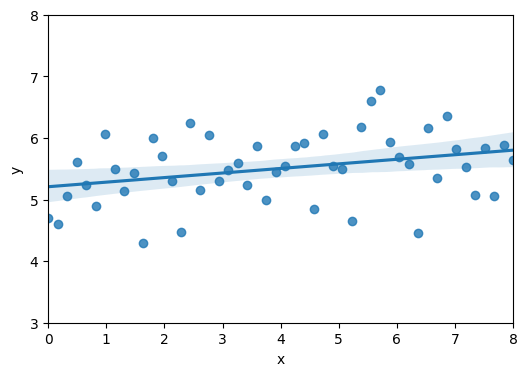

In [2]:
plt.rc('figure', figsize=(6, 4))

N = 50


x = np.linspace(0,8,N)
y = 5 + .1*x + np.random.randn(N)*.5

df1 = pd.DataFrame({'x':x, 'y':y})

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

_ = sns.regplot(x='x', y='y', data = df1, ax = ax)
ax.set_xlim(0, 8)
ax.set_ylim(3, 8)
ticks = ax.set_xticks(list(range(0,9,1)))
ticks = ax.set_yticks(list(range(3,9,1)))

print(df1.corr())

reg = smf.ols('y ~ x', data = df1).fit()
reg.summary()

#### Variações aleatórias

Nessa situação, podemos considerar que estamos extraindo 50 observações das variáveis x e y de forma aleatória de uma população com as característias especificadas.

Observe que a cada vez que rodamos a célula acima, obtemos um valor distinto de $\beta$.

Vamos fazer isso algumas vezes:

In [3]:
betas = []
for i in range(2000):
    x = np.linspace(0,8,N)
    y = .1*x + np.random.randn(N)*.5
    df1 = pd.DataFrame({'x':x, 'y':y})
    reg = smf.ols('y ~ x', data = df1).fit()
    betas.append(reg.params[1])


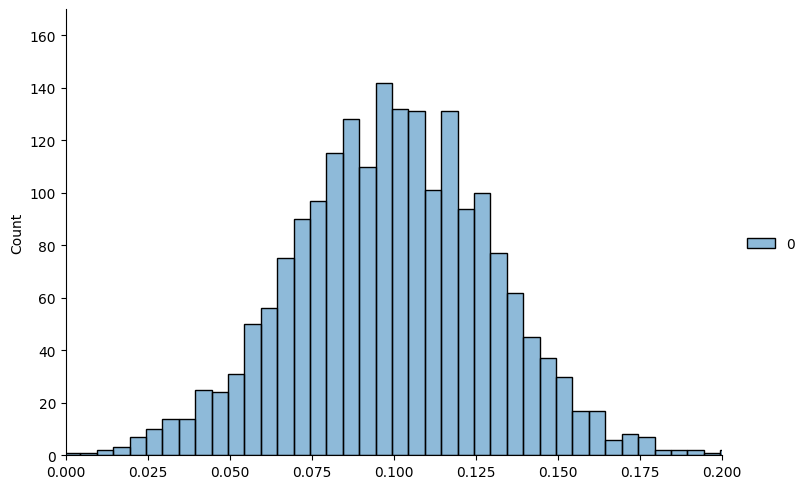

In [4]:
plt.rc('figure', figsize=(20, 10))
g = sns.displot([betas], binwidth = .005, height = 5, aspect = 1.5)
g.set(xlim=(0, 0.2), ylim=(0, 170))

Observe que os valores de $\beta$ estão em torno do verdadeiro valor (0,1), embora sejam aleatórios. 

#### Simulando sob $H_0$
A célula abaixo simula os dados com $\beta = 0$.

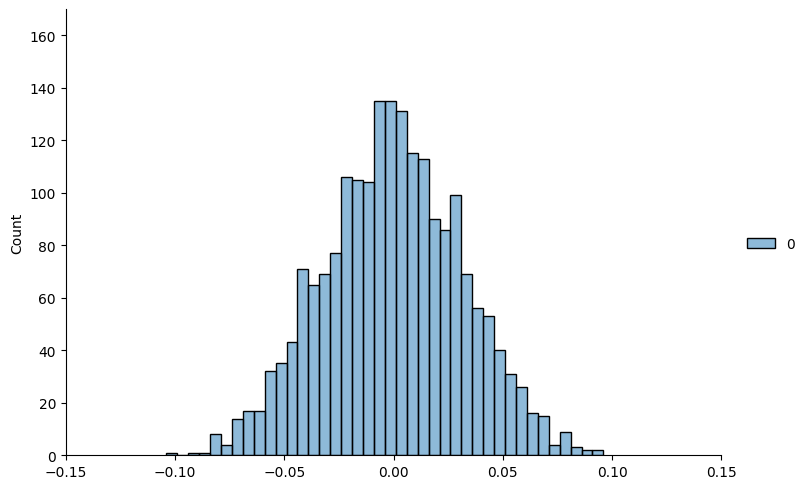

In [5]:
betas = []
for i in range(2000):
    x = np.linspace(0,8,N)
    y = 0*x + np.random.randn(N)*.5
    df1 = pd.DataFrame({'x':x, 'y':y})
    reg = smf.ols('y ~ x', data = df1).fit()
    betas.append(reg.params[1])
    
plt.rc('figure', figsize=(20, 10))
g = sns.displot([betas], binwidth = .005, height = 5, aspect = 1.5)
g.set(xlim=(-0.15, 0.15), ylim=(0, 170))

# sns.displot(betas, binwidth = .005, height = 5, aspect = 1.5)

Observe que os valores obtidos dos $\beta$s se concentram em torno do 0,1, e a frequência diminui quanto mais nos afastamos do valor verdadeiro. Essa distribuição tem a "cara" de uma distribuição muito conhecida e presente em diversas situações, a distribuição Normal (ou Gaussiana). E sim, sob determinadas circunstâncias, a distribuição do $\beta$ é de fato Normal e com um desvio padrão conhecido. O desvio padrão de um parâmetro em geral é chamado por outro nome **erro padrão**, e é ele que aparece na saída do statsmodels com o nome de ``` std err ```.

### 2. Testando hipóteses sobre os parâmetros</span><a name="2"></a>
[Voltar ao índice](#topo)

Queremos saber se uma variável é relevante. Em geral, transformamos as nossas hipóteses para uma afirmação falseável, e sob a qual conseguimos calcular probabilidades. Dessa forma, podemos formular a seguinte hipótese:

$H_0: \beta = 0$  
$H_a: \beta \neq 0$

Assim, sob $H_0$ temos que $\hat{\beta}$ dividido pela estimativa do seu erro padrão (*std err*) tem uma distribuição *t-Student* (que é bem parecida com a normal) centrada em zero. **Esse valor corresponde à coluna ```t```** na saída do statsmodels.    

Em termos práticos significa que se $\beta$ está muito longe do zero (comparado com o seu erro padrão), rejeitamos $H_0$, ou seja, se $H_0$ é falsa, significa que $H_a$ é verdadeira, ou seja, $\beta$ é diferente de zero, o que significa que a variável é relevante no modelo de regressão. 

Caso contrário, não consideramos a variável relevante no modelo e ela pode ser retirada do modelo.

Se você observou um valor $\hat{\beta}_{obs}$ como estimativa do seu beta, uma quantidade muito útil de se calcular é $p(|\hat{\beta}|>\hat{\beta}_{obs})$

Um valor interessante na saída do statsmodels é o ```p>|t|```. Vamos lá: 

- **$\hat{\beta}$ é variável aleatória** ok? Primeiro entenda isso. Ele é uma função dos dados. Como os dados são variáveis aleatórias, qualquer função deles é variável aleatória também. Então ele é variável aleatória.
- O **p-value** é a probabilidade de obtermos um $\hat{\beta}$ mais extremo (maior em valores absolutos) que o observado na nossa amostra, sob $H_0$.
- **Regra prática**: então se o *p-value* é muito pequeno, digamos menor que $(1-\gamma)$, **rejeitamos $H_0$** pois é muito pouco provável observar um beta como estes que observamos sob $H_0$ (Lembra... $H_0$ indica que $\beta=0$ e a variável é irrelevante no modelo). Esse $\gamma$ é o que chamamos de confiança e o $(1-\gamma)$ de significância. Este é o famoso teste de significância aplicado à regressão.
- **Regra de bolso**: muitas pessoas usam 5\% como referência para o *p-value*, outras usam 1\%. Esse assunto realmente dá pano pra manga e não vamos entrar na polêmica aqui. Mas em todo caso, lembre-se da frase do Box, de que "todo modelo está errado" inclusive o seu (e o meu também). A pergunta é o que torna ele útil? E o *p-value* é sem dúvida um valor muito útil.

Vamos ver novamente isso no statsmodels:

         x        y
x  1.00000  0.54001
y  0.54001  1.00000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     19.76
Date:                Sun, 09 Jul 2023   Prob (F-statistic):           5.18e-05
Time:                        12:59:58   Log-Likelihood:                -37.778
No. Observations:                  50   AIC:                             79.56
Df Residuals:                      48   BIC:                             83.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9546      0.146     33.821      0.000       4.660       5.249
x              0.1403      0.032      4.445      0.000       0.077       0.204
==============================================================================
Omnibus:                        0.023   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.185
Skew:                          -0.030   Prob(JB):                        0.912
Kurtosis:                       2.708   Cond. No.                         9.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

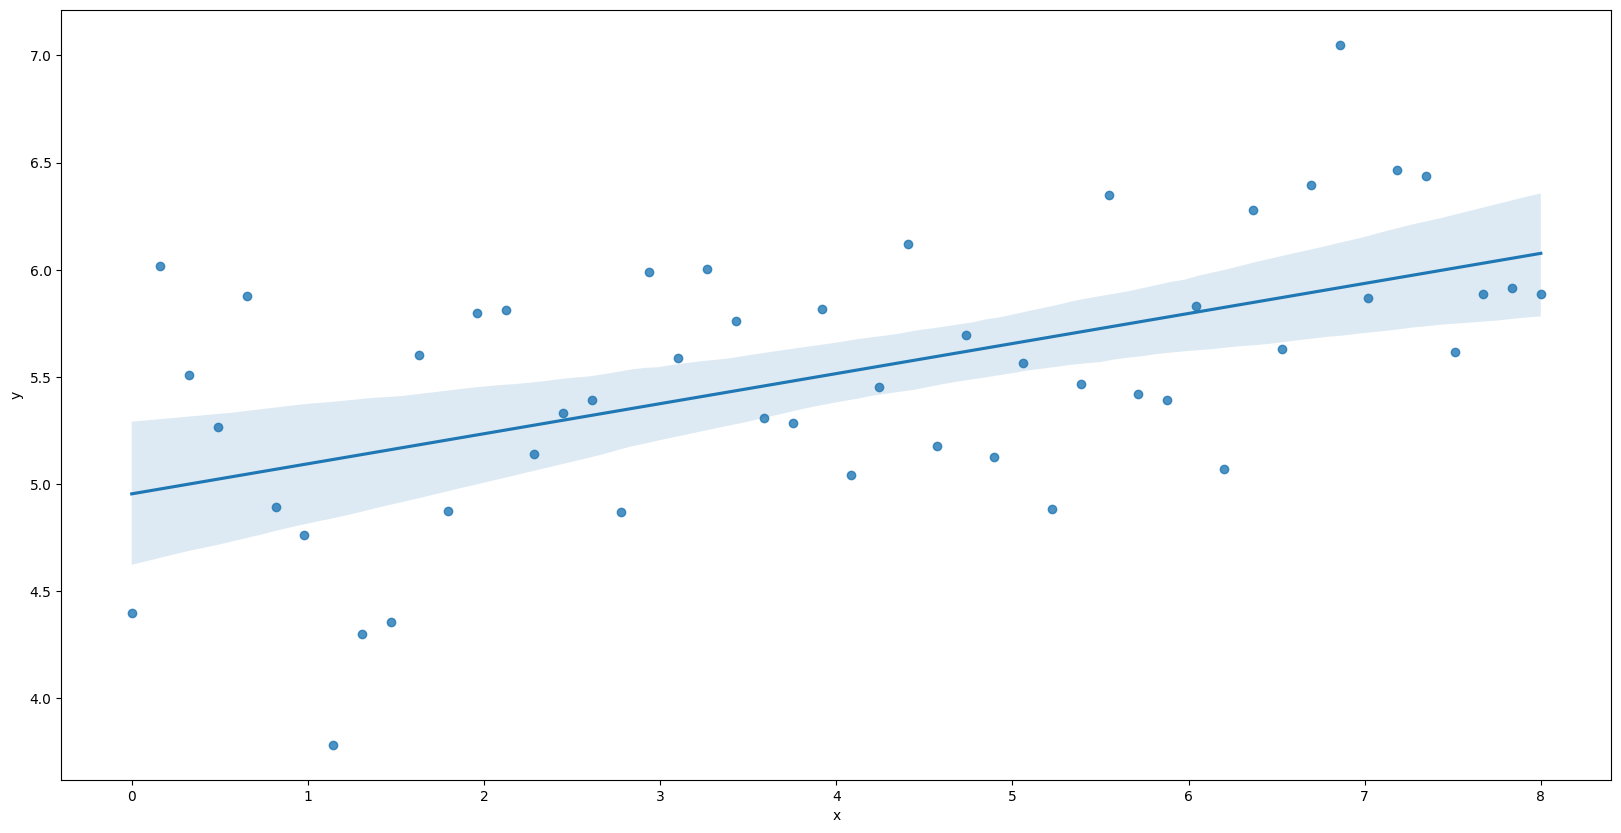

In [6]:
N = 50


x = np.linspace(0,8,N)
y = 5 + .1*x + np.random.randn(N)*.5

df1 = pd.DataFrame({'x':x, 'y':y})

_ = sns.regplot(x='x', y='y', data = df1)
print(df1.corr())

reg = smf.ols('y ~ x', data = df1).fit()
reg.summary()

### Vamos simular um caso em que $H_0$ é verdadeira

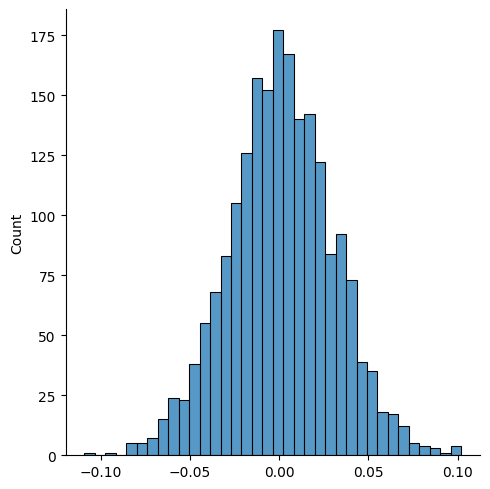

In [7]:
betas = []
for i in range(2000):
    x = np.linspace(0,8,N)
    y = 0*x + np.random.randn(N)*.5
    df1 = pd.DataFrame({'x':x, 'y':y})
    reg = smf.ols('y ~ x', data = df1).fit()
    betas.append(reg.params[1])
    
sns.displot(betas)

#### Observação sobre o teste de significância
Repare que os valores simulados de $\beta$ se distribuem ao longo do verdadeiro valor, que é o zero neste caso, e chegam bem próximoes de 0.1 e -0.1. Se fazemos o nosso teste com 5% de significância, quer dizer que 5% das vezes (1 em cada 20) $H_0$ vai ser verdadeira, mas vamos ter a conclusão errada. Esse é o famoso **erro tipo I** dos testes de hipóteses.

### 3. Variáveis qualitativas </span><a name="3"></a>
[Voltar ao índice](#topo)

Já vimos que para tratar variáveis qualitativas precisamos transformá-las em *dummies*, processo este conhecido como *"hot encoding"* ou simplesmente *"encoding"*.

Antes de partir para o próximo tema, vamos mergulhar um pouco mais fundo no entendimento das variáveis *dummy*.

In [8]:
tips = sns.load_dataset("tips")
tips['tip_pct'] = tips['tip'] / (tips['total_bill'] - tips['tip'])
tips['net_bill'] = tips['total_bill'] - tips['tip']
tips.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct,net_bill
0,16.99,1.01,Female,No,Sun,Dinner,2,0.063204,15.98
1,10.34,1.66,Male,No,Sun,Dinner,3,0.191244,8.68
2,21.01,3.50,Male,No,Sun,Dinner,3,0.199886,17.51
3,23.68,3.31,Male,No,Sun,Dinner,2,0.162494,20.37
4,24.59,3.61,Female,No,Sun,Dinner,4,0.172069,20.98


<Axes: xlabel='size', ylabel='tip'>

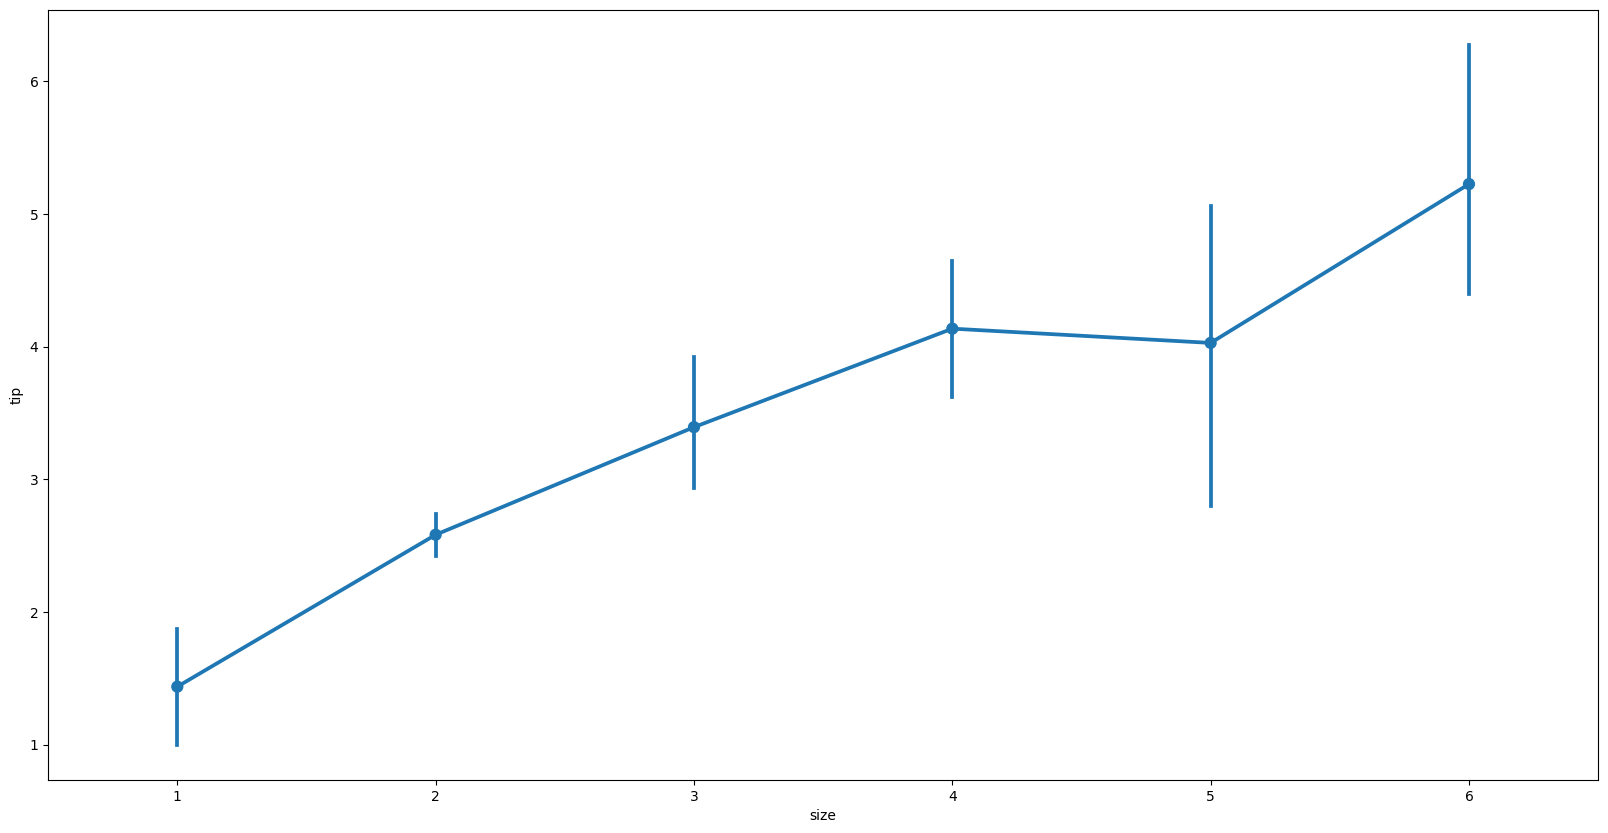

In [9]:
sns.pointplot(y = 'tip', x = 'size', data = tips)

In [10]:
y, x = patsy.dmatrices('tip ~ C(size)', data = tips)
x

DesignMatrix with shape (244, 6)
  Columns:
    ['Intercept',
     'C(size)[T.2]',
     'C(size)[T.3]',
     'C(size)[T.4]',
     'C(size)[T.5]',
     'C(size)[T.6]']
  Terms:
    'Intercept' (column 0), 'C(size)' (columns 1:6)
  (to view full data, use np.asarray(this_obj))

In [11]:
data = pd.DataFrame({'size': [1, 2, 3, 5, 4]})
data

,size
0,1
1,2
2,3
3,5
4,4


In [12]:
from patsy import dmatrix
dmatrix("C(size)", data)

DesignMatrix with shape (5, 5)
  Intercept  C(size)[T.2]  C(size)[T.3]  C(size)[T.4]  C(size)[T.5]
          1             0             0             0             0
          1             1             0             0             0
          1             0             1             0             0
          1             0             0             0             1
          1             0             0             1             0
  Terms:
    'Intercept' (column 0)
    'C(size)' (columns 1:5)

In [13]:
y, x = patsy.dmatrices('tip ~ C(size)', data = tips)
x

DesignMatrix with shape (244, 6)
  Columns:
    ['Intercept',
     'C(size)[T.2]',
     'C(size)[T.3]',
     'C(size)[T.4]',
     'C(size)[T.5]',
     'C(size)[T.6]']
  Terms:
    'Intercept' (column 0), 'C(size)' (columns 1:6)
  (to view full data, use np.asarray(this_obj))

In [14]:
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     15.75
Date:                Sun, 09 Jul 2023   Prob (F-statistic):           2.17e-13
Time:                        13:00:08   Log-Likelihood:                -390.09
No. Observations:                 244   AIC:                             792.2
Df Residuals:                     238   BIC:                             813.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.4375      0.606      2.372      0.018       0.244       2.631
C(size)[T.2]     1.1448      0.614      1.865      0.063      -0.064       2.354
C(size)[T.3]     1.9557      0.637      3.070      0.002       0.701       3.211
C(size)[T.4]     2.6979      0.638      4.229      0.000       1.441       3.955
C(size)[T.5]     2.5905      0.813      3.186      0.002       0.989       4.192
C(size)[T.6]     3.7875      0.857      4.420      0.000       2.099       5.476
==============================================================================
Omnibus:                       77.409   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.825
Skew:                           1.344   Prob(JB):                     6.87e-54
Kurtosis:                       7.106   Cond. No.                         24.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
1.4375 + 1.1448

2.5823

In [16]:
y, x = patsy.dmatrices('tip ~ C(size, Treatment(2))', data = tips)
x

DesignMatrix with shape (244, 6)
  Columns:
    ['Intercept',
     'C(size, Treatment(2))[T.1]',
     'C(size, Treatment(2))[T.3]',
     'C(size, Treatment(2))[T.4]',
     'C(size, Treatment(2))[T.5]',
     'C(size, Treatment(2))[T.6]']
  Terms:
    'Intercept' (column 0), 'C(size, Treatment(2))' (columns 1:6)
  (to view full data, use np.asarray(this_obj))

In [17]:
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     15.75
Date:                Sun, 09 Jul 2023   Prob (F-statistic):           2.17e-13
Time:                        13:00:08   Log-Likelihood:                -390.09
No. Observations:                 244   AIC:                             792.2
Df Residuals:                     238   BIC:                             813.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      2.5823      0.097     26.613      0.000       2.391       2.773
C(size, Treatment(2))[T.1]    -1.1448      0.614     -1.865      0.063      -2.354       0.064
C(size, Treatment(2))[T.3]     0.8109      0.219      3.698      0.000       0.379       1.243
C(size, Treatment(2))[T.4]     1.5531      0.222      7.008      0.000       1.117       1.990
C(size, Treatment(2))[T.5]     1.4457      0.551      2.626      0.009       0.361       2.530
C(size, Treatment(2))[T.6]     2.6427      0.614      4.306      0.000       1.434       3.852
==============================================================================
Omnibus:                       77.409   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.825
Skew:                           1.344   Prob(JB):                     6.87e-54
Kurtosis:                       7.106   Cond. No.                         8.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4. Qualidade do modelo e complexidade</span><a name="4"></a>
[Voltar ao índice](#topo)

Quando fazemos uma regressão múltipla, pelo próprio método de mínimos quadrados ordinários, a métrica $R^2$ vai ser necessariamente melhor sempre que adicionarmos uma variável a mais. Sempre. Por menos sentido que a variável faça, por menos informação que ela agregue, o $R^2$ vai ser maior (ou no pior extremo caso, igual) ao que tínhamos antes.

Vamos ver isso na prática na base de gorjetas:

In [18]:
reg = smf.ols('tip ~ C(size, Treatment(2)) + np.log(net_bill)', data = tips).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     21.03
Date:                Sun, 09 Jul 2023   Prob (F-statistic):           9.61e-20
Time:                        13:00:14   Log-Likelihood:                -372.87
No. Observations:                 244   AIC:                             759.7
Df Residuals:                     237   BIC:                             784.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.3279      0.494     -0.664      0.508      -1.301       0.645
C(size, Treatment(2))[T.1]    -0.1059      0.599     -0.177      0.860      -1.285       1.074
C(size, Treatment(2))[T.3]     0.4012      0.216      1.859      0.064      -0.024       0.826
C(size, Treatment(2))[T.4]     0.8693      0.236      3.679      0.000       0.404       1.335
C(size, Treatment(2))[T.5]     0.6797      0.530      1.283      0.201      -0.364       1.724
C(size, Treatment(2))[T.6]     1.7283      0.593      2.914      0.004       0.560       2.897
np.log(net_bill)               1.1401      0.190      5.993      0.000       0.765       1.515
==============================================================================
Omnibus:                       74.766   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.626
Skew:                           1.303   Prob(JB):                     5.05e-51
Kurtosis:                       6.999   Cond. No.                         28.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Vamos inserir a variavel *day* e checar os resultados

In [19]:
reg = smf.ols('tip ~ C(size, Treatment(2)) + np.log(net_bill) + day', data = tips).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     13.96
Date:                Sun, 09 Jul 2023   Prob (F-statistic):           6.16e-18
Time:                        13:00:31   Log-Likelihood:                -372.52
No. Observations:                 244   AIC:                             765.0
Df Residuals:                     234   BIC:                             800.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.3904      0.504     -0.775      0.439      -1.383       0.602
C(size, Treatment(2))[T.1]    -0.1007      0.605     -0.166      0.868      -1.293       1.092
C(size, Treatment(2))[T.3]     0.3880      0.221      1.757      0.080      -0.047       0.823
C(size, Treatment(2))[T.4]     0.8480      0.242      3.510      0.001       0.372       1.324
C(size, Treatment(2))[T.5]     0.6527      0.536      1.217      0.225      -0.404       1.709
C(size, Treatment(2))[T.6]     1.7578      0.604      2.911      0.004       0.568       2.947
day[T.Fri]                     0.1562      0.301      0.520      0.604      -0.436       0.749
day[T.Sat]                     0.0385      0.195      0.197      0.844      -0.346       0.423
day[T.Sun]                     0.1393      0.202      0.689      0.491      -0.259       0.537
np.log(net_bill)               1.1395      0.192      5.931      0.000       0.761       1.518
==============================================================================
Omnibus:                       75.986   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              240.004
Skew:                           1.318   Prob(JB):                     7.65e-53
Kurtosis:                       7.082   Cond. No.                         28.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Observações

- O $R^2$ aumentou, embora a variável adicionada não pareça ser significante.
- O $R^2$ sempre vai aumentar. Na pior das hipóteses ele fica igual.
- O modelo ficou mais "complicado".
- Estamos aumentando o risco de "overfitting".
- Esta variável adicional interfere nas estimativas dos demais parâmetros.

### Navalha de Occam

Um princípio conhecido como *[Navalha de Occam](https://en.wikipedia.org/wiki/Occam%27s_razor)* indica que se temos dois modelos com indicadores iguais de qualidade, e um é mais simples, o mais simples é desejável. Dessa forma, diversas propostas surgem na tentativa de "balisar" a quantidade de parâmetros no modelo, como o $R^2$-*ajustado* - que sofre uma penalização por cada parâmetro no modelo e o AIC que vamos discutir adiante.

Com isso em mente, há na literatura diversas alternativas para se considerar a complexidade do modelo na medida de qualidade, como o critério de Akaike (AIC) e o $R^2-ajustado$.

#### AIC

*Akaike´s Information Criterion* (ou critério da informação de Akaike). É uma métrica mais "estatística" de qualidade de ajuste do modelo, desenhada para comparar modelos com diferentes combinações de variáveis. Quanto menor o AIC, melhor o modelo - ou seja, se colocamos uma nova variável no modelo, por esse critério ela é relevante se o AIC diminuir, e não é relevante caso contrário. 

Diferente do $R^2$, o AIC depende do tamanho da amostra, de modo que não tem uma 'regra de bolso' do tipo "perto de 1 é bom", mas é adequado para comparar modelos na mesma amostra.

A Wikipedia tem um artigo interessante sobre o [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion).

#### $R^2-ajustado$

O $R^2$-ajustado procura ponderar o incremento em explicação da variabilidade com o incremento em complexidade do modelo em termos de número de parâmetros. Ele aumenta se o $R^2$ aumentar mais do que o esperado "por acaso", e diminui caso contrário. Sua fórmula é a seguinte:

$$R^2_{aj} = 1- \left[ \frac{(1-R^2)(n-1)}{(n-k-1)} \right]$$

#### Observações do exemplo anterior
Repare que, no exercício anterior, quando inserimos uma variável irrelevante no modelo, o $R^2$ aumentou, mas o $R^2-ajustado$ diminuiu e o AIC aumentou, sugerindo que esta variável não deve entrar no modelo.

### 5. Seleção de modelos </span><a name="5"></a>
[Voltar ao índice](#topo)

Três algoritmos clássicos na literatura estatística para seleção de variáveis:

- *Forward*:  
    Parte de um modelo vazio e vai incluindo variáveis estatisticamente relevantes uma a uma, priorizando a mais relevante, até que nenhuma seja incluída. Pode haver alguma variável que deixou de ser relevante na presença daquelas que foram incluídas depois.
    1. Definir um limite *LI* de *p-value* para uma variável ser **incluída** no modelo
    2. Iniciar com um modelo sem variáveis
    3. Para cada variável fora do modelo, testar $\beta = 0$ na presença das demais - armazenar o *p-value*
    4. Se o menor *p-value* for menor que *L*, a variável correspondente é incluída no modelo
    5. Repetir 3 e 4 até que não sejam adicionadas variáveis ao modelo
    <br><br>
- *Backward*:  
    Parte de um modelo com todas as variáveis possíveis consideradas e vai removendo-as uma a uma, até que nenhuma seja removida. Pode haver variáveis relevantes ainda após o término.
    1. Definir um limite *LE* de *p-value* para uma variável ser **excluída** do modelo
    2. Para cada variável incluída no modelo, testar $\beta = 0$ na presença das demais - armazenar o *p-value*
    3. Se o menor *p-value* for maior que *LE*, a variável é excluída do modelo
    5. Repetir 3 e 4 até que não sejam excluídas mais variáveis do modelo
- *Stepwise*:
    É básicamente uma mistura dos dois. Vai incluindo variáveis, eventualmente removendo alguma variável caso seja irrelevante na presença das demais.
    
**Crítica**: Essa abordagem é criticada na comunidade porque esse *p-value* é tido mais como uma referência. Muitos usam esse algoritmo com o critério de Akaike ao invés do *p-value*, ou mesmo as regularizações L1 e L2, com a qual é possível fazer um *grid search* para buscar melhores resultados em previsão.

De qualquer forma, a seleção de um modelo por um desses algoritmos **muito raramente** (pra não dizer nunca) é a escolha final. Sempre há insights e ajustes a serem feitos, categorias a agrupar, variáveis conceitualmente importantes que podem ser priorizadas, multicolinearidade a ser tratada (mais sobre isso adiante), enfim, é um processo meio arte meio ciência suportado por algoritmos menos que executado por algoritmos.

O código abaixo foi extraído e adaptado do fórum [*stackovervlow*](https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-a-forward-selection-stepwise-regression-algorithm), da resposta do David Dale.

In [37]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import statsmodels.api as sm

data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=np.dtype('float64'))
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                 print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        print("#############")
        print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

variaveis = stepwise_selection(X, y)

print('resulting features:')
print(variaveis)

Add  LSTAT                          with p-value 5.0811e-88
#############
['LSTAT']
Add  RM                             with p-value 3.47226e-27
#############
['LSTAT', 'RM']
Add  PTRATIO                        with p-value 1.64466e-14
#############
['LSTAT', 'RM', 'PTRATIO']
Add  DIS                            with p-value 1.66847e-05
#############
['LSTAT', 'RM', 'PTRATIO', 'DIS']
Add  NOX                            with p-value 5.48815e-08
#############
['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX']
Add  CHAS                           with p-value 0.000265473
#############
['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS']
Add  B                              with p-value 0.000771946
#############
['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B']
Add  ZN                             with p-value 0.00465162
#############
['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN']
Add  CRIM                           with p-value 0.0445675
#############
['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX

### 6. Regularização </span><a name="6"></a>
[Voltar ao índice](#topo)

Regularização (ou *model regularization*) é uma forma de considerar a complexidade adicionada ao modelo e simplificar o modelo, quer seja por deixar os parâmetros menos relevantes, quer seja por retirá-los intrgralmente do modelo.

As duas formas mais populares na literatura do aprendizado de máquina são a regularização L1 e a regularização L2:

#### Função de perda
Vamos relembrar que a nossa regressão é uma regressãod e mínimos quadrados, ou seja, estamos minimizando a função do erro quadrático médio (EQM) em função dos parâmetros do modelo ($\beta_0, \beta_1, \beta_2, ..., \beta_n$). Nossa função de erro, podemos chamá-la de um nome mais geral: *função de perda* L:

$$L = \sum_{n=1}^{N} \left( y_i - \hat{y_i} \right)^2$$

As formas de regularização mais populares introduzem uma "penalização" na função de perda devido ao aumento na complexidade do modelo - isto é, devido ao aumento do número de parâmetros (ou variáveis) no modelo.

#### Regularização L1 (lasso)
A regressão lasso introduz uma penalidade igual ao quadrado da soma dos coeficientes na função de perda:

$$L_1 = \sum_{i=1}^{N} \left( y_i - \hat{y_i} \right)^2 + \alpha \sum_{k=0}^{M} \left| \beta_k \right|$$

Em que:  
- $\beta_k$ são os parâmetros do modelo (atenção que $\beta_0$ é o intercepto).
- N é o número de observações
- M é o número de parâmetros
- $\alpha$ no statsmodels é um *hiperparâmetro* do modelo, que regula a penalidade por complexidade.

Dessa forma, minimizando essa função de perda, os parâmetros do modelo tendem a ter valor absoluto menor, e caso tragam mais complexidade que explicação da variância, são "zerados", o que significa que a variável correspondente fica é eliminada do modelo.

#### Regularização L2 (ridge)
Outra forma de regularização é a chamada regularização *ridge*, que minimiza a seguinte perda:

$$L_2 = \sum_{i=1}^{N} \left( y_i - \hat{y_i} \right)^2 + \alpha \sum_{k=0}^{M} \left| \beta_k \right|^2$$

Em que:  
- $\beta_k$ são os parâmetros do modelo (atenção que $\beta_0$ é o intercepto).
- N é o número de observações
- M é o número de parâmetros
- $\alpha$ no statsmodels é um *hiperparâmetro* do modelo, que regula a penalidade por complexidade.

Essa regularização é semelhante ao *lasso*, porém a penalização é no valor absoluto dos parâmetros. Diferente do lasso, não costuma "zerar" os parâmetros das variáveis menos relevantes, somente reduzir os coeficientes.

#### *Elastic net*
Uma forma bem popular de regularização de regressão é o *elastic net*, que consiste na mistura dos dois otimizando a seguinte função de perda:

$$L_E = \sum_{i=1}^{N} \left( y_i - \hat{y_i} \right)^2 
    + \alpha \left( L1_{wt} \sum_{k=0}^{M} \left| \beta_k \right|
                    + (1-L1_{wt}) \sum_{k=0}^{M} \left( \beta_k \right)^2
             \right)$$

com:  
- N é o número de observações e M o número de parâmetros
- $\alpha$ sendo o hiperparâmetro que dá importância à penalização  
- $L1_{wt}$ sendo um número entre 0 e 1 
    - quando vale 1, equivale regulaziração L1 - lasso
    - quando 0 equivale a L2 - ridge
    


#### Vamos testar

Vamos usar o Lasso, pois é uma forma interessante de fazer seleção de variáveis no modelo.

In [46]:
# Regularization
modelo = 'tip ~ C(size) + np.log(net_bill) + smoker + time + day'
md = smf.ols(modelo, data = tips)
reg = md.fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.01)

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     15.72
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           1.62e-18
Time:                        16:56:56   Log-Likelihood:                -372.83
No. Observations:                 244   AIC:                             763.7
Df Residuals:                     236   BIC:                             795.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0943      0.553     -0.171      0.865      -1.183       0.995
C(size)[T.2]        -0.3591      0.197     -1.819      0.070      -0.748       0.030
C(size)[T.3]              0          0        nan        nan           0           0
C(size)[T.4]         0.4563      0.256      1.782      0.076      -0.048       0.961
C(size)[T.5]              0          0        nan        nan           0           0
C(size)[T.6]         1.3854      0.610      2.270      0.024       0.183       2.588
smoker[T.No]        -0.0929      0.156     -0.596      0.552      -0.400       0.214
time[T.Dinner]       0.0376      0.185      0.203      0.839      -0.326       0.401
day[T.Fri]                0          0        nan        nan           0           0
day[T.Sat]                0          0        nan        nan           0           0
day[T.Sun]           0.1234      0.178      0.692      0.490      -0.228       0.475
np.log(net_bill)     1.1883      0.178      6.693      0.000       0.839       1.538
==============================================================================
Omnibus:                       72.687   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.153
Skew:                           1.276   Prob(JB):                     2.58e-48
Kurtosis:                       6.879   Cond. No.                         67.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            print(included+[new_column])
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
from sklearn.datasets import load_boston

data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [ ]:
result = stepwise_selection(X, y)

print('resulting features:')
print(result)

In [ ]:
reg_stepwise = sm.OLS(y, sm.add_constant(pd.DataFrame(X[variaveis]))).fit()
reg_stepwise.summary()

#### *Best subsets*

In [ ]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
# Could take quite awhile to complete...
import itertools
import time

models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

In [ ]:
models_best

In [ ]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return models

In [ ]:
models = getBest(3)

In [ ]:
models.sort_values('RSS')

In [ ]:
X

In [ ]:
import scipy.stats as stats

mu = 0

sigma = 1
x = np.linspace(-5, 5, 500)
plt.plot(x, stats.norm.pdf(x, 0, 1))

xinf = np.linspace(-5, stats.norm.ppf(.025, 0, 1), 500)
plt.fill_between(xinf, stats.norm.pdf(xinf, 0, 1), color = 'orange')

xsup = np.linspace(stats.norm.ppf(.975, 0, 1), 5 , 500)
plt.fill_between(xsup, stats.norm.pdf(xsup, 0, 1), color = 'orange')


plt.show()

In [ ]:
xinf = np.linspace(-5, stats.norm.ppf(.025, 0, 1), 500)
plt.fill_between(xinf, stats.norm.pdf(xinf, 0, 1))

xsup = np.linspace(stats.norm.ppf(.975, 0, 1), 5 , 500)
plt.fill_between(xsup, stats.norm.pdf(xsup, 0, 1))



In [ ]:
import patsy
from patsy import balanced
from patsy import dmatrix

In [ ]:
patsy.dmatrix("C(a, Diff)", balanced(a=3))

In [ ]:
balanced(a=3)

In [ ]:
from patsy import dmatrix
from patsy import demo_data

data = demo_data("a", nlevels=3)
l = ["a3", "a2", "a1"]

dmatrix("C(a, levels=l)", data)

In [ ]:
ordinal = [[0, 0], [0, 1], [1, 1]]

dmatrix("C(a, ordinal)", data)